# Uncomment this if working in GoogleColab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# THE PATH MAY NEED TO BE CHANGED TO YOUR OWN PATH
%cd "/content/drive/MyDrive/DeepLearning/P2"

/content/drive/MyDrive/DeepLearning/P2


## Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random
from typing import List
import pickle

## Global variables

In [ ]:
output_path = "Results/"
input_path = "Data/"
seed_value = 10
save_figure = True
use_accel = True # Only uses GPU acceleration if available. Always leave it as True.

## General utility functions

In [ ]:
def allocate(item: torch.Tensor, use_acceleration=True, verbose=False) -> torch.Tensor:
    """
    Given a torch element, it allocates it in the CPU or the GPU as specified
    by use_cuda (which allocates it in the GPU).
    """
    device = 'cpu'

    if use_acceleration and torch.cuda.is_available():
        device = 'cuda'
    elif use_acceleration and torch.backends.mps.is_available():
        device = 'mps'

    if verbose: print(f"Computation allocated on {device}.")
    return item.to(device=device, dtype=None)


def split_and_join(sentences: List[str]) -> List[str]:
    """
    Given a list of strings, it returns a list of characters, in order.
    """
    output = "".join(sentences)
    return list(output)


## Exercise 2 utility functions

In [ ]:
def uppercase_to_num(uppercase_letter: str, vocabulary: List[str]) -> int:
    """
    Given a letter in the range A-Z (plus the hyphen for corrupted letters), it
    returns its numerical code. The numerical code corresponds to the position
    of the given uppercase_letter in the vocabulary list.
    """
    return vocabulary.index(uppercase_letter)


def num_to_uppercase(number: int, vocabulary: List[str]) -> str:
    """
    Given a number in the range 0-len(vocabulary), it returns the corresponding
    letter for the number code. 
    """
    return vocabulary[number]


def sentence_to_num(sentence: str, vocabulary: List[str]) -> torch.Tensor:
    """
    Change a sentence written with letters to a numerical representation
    (required for training with PyTorch)
    """
    output = []
    for word in sentence:
        output.append(uppercase_to_num(word, vocabulary))
    return torch.Tensor(output).long()


def encrypt_message(plaintext, keyword, vocabulary):
    """
    Given a message and keyword, it encrypts the message using the Vigenere
    cypher. It returns the encrypted message (still written with letters).
    """
    cyphertext = ""
    for i in range(len(plaintext)):
        p = uppercase_to_num(plaintext[i], vocabulary)
        k = uppercase_to_num(keyword[i], vocabulary)
        c = (p + k) % 26
        cyphertext += num_to_uppercase(c, vocabulary)

    return cyphertext

# Ex.1 - Experimenting with Multi-Class Sequence Classification using RNNs and LSTMs

Experimenting with Multi-Class Sequence Classification using RNNs and LSTMs

**Steps**:

1. Load and visualize the training and testing data in `'data/P2_E1.csv'` as shown in the following code cell.

2. Following section 2 in the examples, train a RNN or LSTM to solve the multi-class sequence classification problem:

    - Adapt the classification loss and the `SequenceClassifier` module

    - Adapt the `test_sequence_classifier` function to compute the multi-class accuracy and be able to visualize the confusion matrix

3. Experiment with different models by changing different hyper-parameters (e.g, `num_layers`, `hidden_size`, `optimiziers`, `activation_functions` for RNNs, etc..) and evaluate  the results for each of them on the testing set.

4. Visualize analyse and discuss the results in the report.

## Load and visualize the data

<class 'numpy.ndarray'>
Train sequences shape: (210, 40)
Train labels shape: (210,)
Test sequences shape: (90, 40)
Test labels shape: (90,)


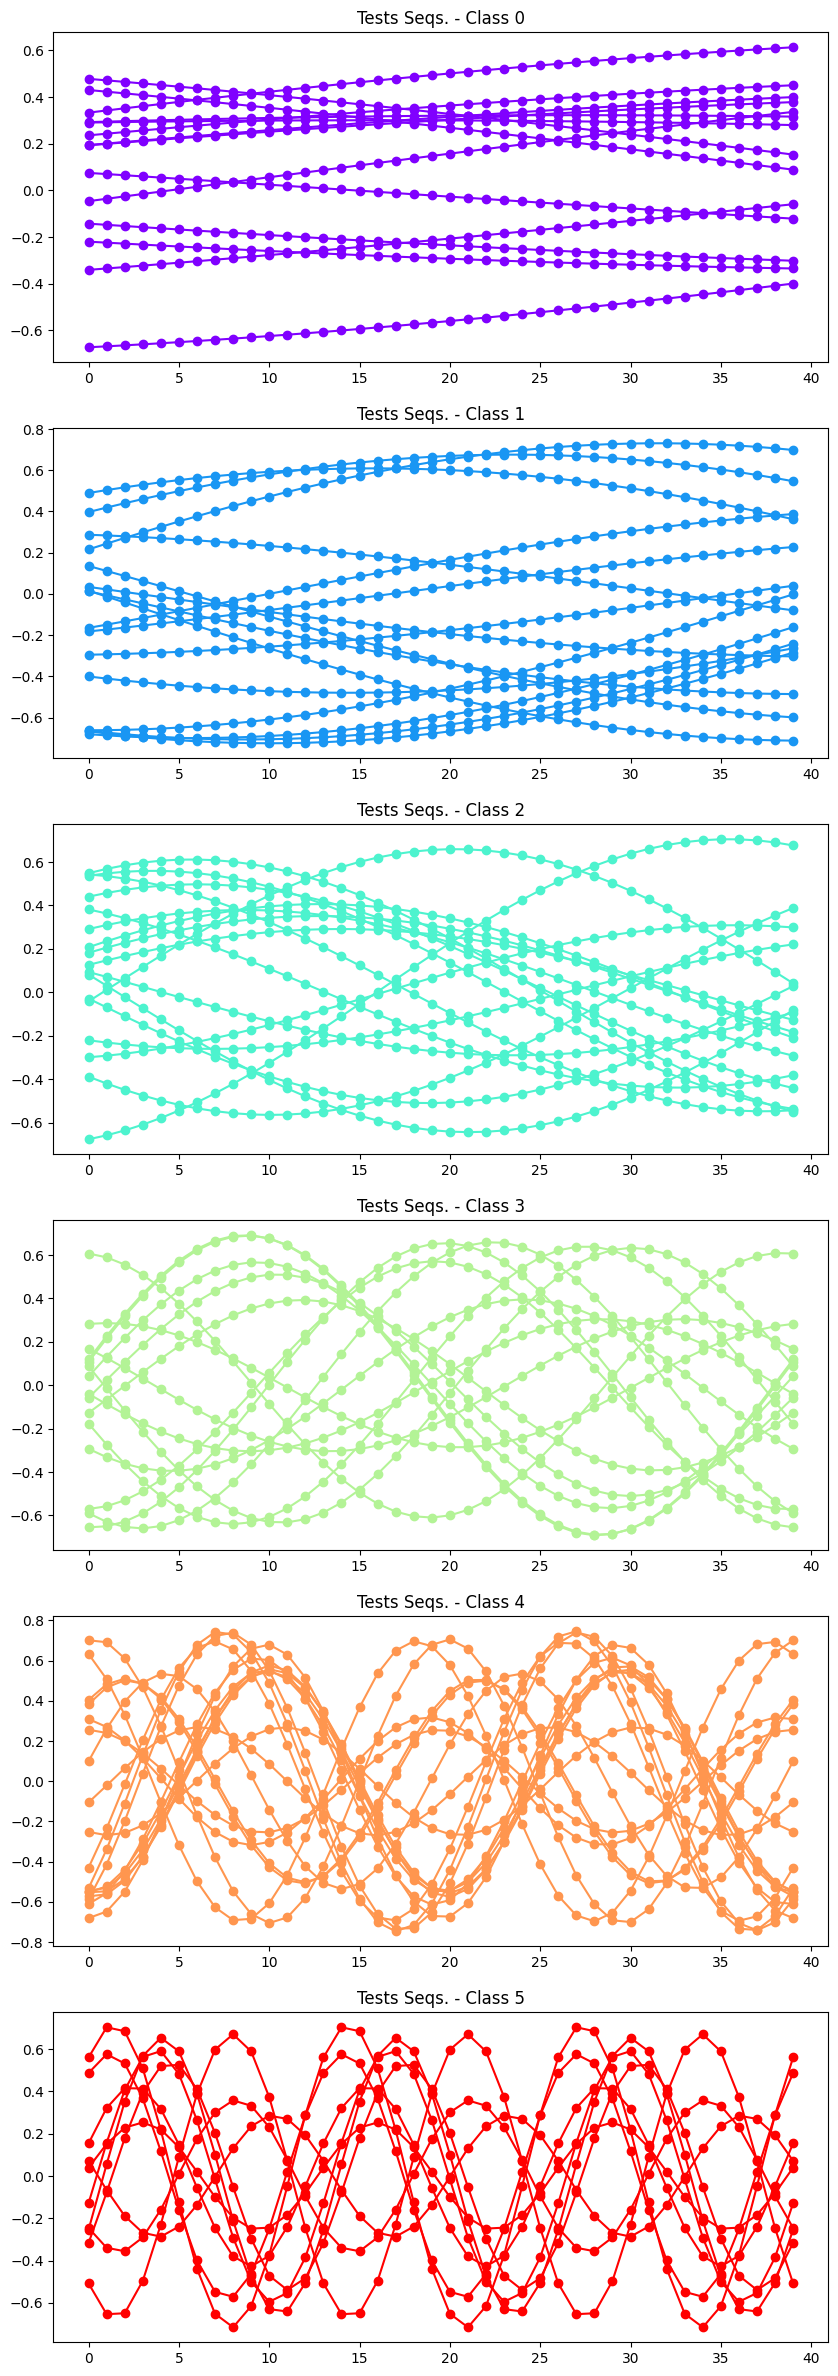

In [ ]:
# Load data

data = np.load(input_path + "P2_E1.npz")
X_train, X_test = data["X_train"], data["X_test"]
Y_train, Y_test = data["Y_train"], data["Y_test"]

print(type(X_train))

# Check data size and shape

print(f"Train sequences shape: {X_train.shape}") # (210, 40) (# sequences, # datapoints per sequence)
print(f"Train labels shape: {Y_train.shape}") # Train Labels: (210,)  (# of sequences, )
print(f"Test sequences shape: {X_test.shape}")
print(f"Test labels shape: {Y_test.shape}")

# Get the number of different classes of the multiclass classification

classes = np.unique(Y_train)
n_classes = len(classes)

# Visualise the data

colors = plt.cm.rainbow(np.linspace(0, 1, n_classes))

fig1, axs = plt.subplots(n_classes, 1, figsize=(10, 5 * n_classes))
for class_idx in range(0, n_classes):
    axs[class_idx].plot(X_test[Y_test == class_idx, :].T, "-o", c=colors[class_idx])
    axs[class_idx].set_title(f"Tests Seqs. - Class {class_idx}")

if save_figure: plt.savefig(f"{output_path}fig1.png", dpi=300)

plt.show()

## Train a RNN or LSTM to solve the multi-class sequence classification problem.

- Adapt the classification loss and the `SequenceClassifier` module

- Adapt the test_sequence_classifier function to compute the multi-class accuracy and be able to visualize the confusion matrix

### `SequenceClassifier` class

In [ ]:
# Define module encapsulating a Sequence Classifier using RNN or LSTMs and setting different architecture hyper-parameters
class SequenceClassifier(nn.Module):
    def __init__(self, input_size: int = 1, hidden_size: int = 5, num_layers: int = 1, use_lstm: bool = False, bias: bool = False, dropout: float = 0, n_classes: int = 2):
        super().__init__()
        self.use_lstm = use_lstm

        if use_lstm:
            self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, bias=bias, bidirectional=False, dropout=dropout)
        else:
            self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, bias=bias, dropout=dropout)

        self.activation = nn.Softmax(dim=1) # FIXME: Change if necessary
        self.last_linear = nn.Linear(hidden_size, n_classes)


    def forward(self, X):
        _, last_states = self.rnn(X)
        # Get last hidden state for last layer. Ignore cell state in case of LSTMs
        if not self.use_lstm:
            last_hidden_state = last_states[-1, :, :].squeeze(0)
        else:
            last_hidden_state = last_states[0][-1, :, :].squeeze(0)
        # Get sequence label probability using the last hidden state
        output = self.activation(self.last_linear(last_hidden_state))
        return output

### Training and testing functions

In [ ]:
def train_sequence_classifier(X_train, Y_train, seq_classifier: SequenceClassifier, optimizer, loss_func, seed_value, dropout=0, epochs=100):
    """
    Given a dataset (with points and target labels), trains a SequenceClassifier.
    """
    torch.manual_seed(seed_value) # Ensures that all trainings use the same random numbers
    loss_its = []
    dropout = nn.Dropout(p=dropout)
    for iter in range(epochs):
        optimizer.zero_grad()
        output = seq_classifier(X_train)
        output = dropout(output)
        loss = loss_func(output, Y_train)
        loss_its.append(loss.item())
        loss.backward()
        optimizer.step()

    print(f"Final loss: {loss.item()}")
    return np.asarray(loss_its)


def test_sequence_classifier(X_test, Y_test, seq_classifier):
    """
    Given a dataset (with points and target labels), computes the accuracy of the model.
    """
    output = seq_classifier(X_test)
    classification = torch.argmax(output, dim=1)

    # Computation of the confusion matrix cannot be done in the GPU
    classification = allocate(classification, use_acceleration=False)
    Y_test = allocate(Y_test, use_acceleration=False)

    conf_matrix = confusion_matrix(y_true=Y_test, y_pred=classification, normalize=None)
    accuracy = (torch.sum(classification == Y_test) / output.shape[0]).item()

    print(f"Test Accuracy: {np.round(accuracy * 100, decimals=3)} %")
    return accuracy, conf_matrix


## Experiment with different models by changing different hyper-parameters
(e.g, num_layers, hidden_size, optimiziers, activation_functions for RNNs, etc..) and evaluate  the results for each of them on the testing set.

In [ ]:
# Dataset to PyTorch format
X_train_pt = allocate( torch.from_numpy(X_train).float().unsqueeze(2), use_accel )
Y_train_pt = allocate( torch.from_numpy(Y_train).long(), use_accel )
X_test_pt = allocate( torch.from_numpy(X_test).float().unsqueeze(2), use_accel )
Y_test_pt = allocate( torch.from_numpy(Y_test).long(), use_accel )

print('\nX_train and Y_train shape after being moved to torch:')
print(X_train_pt.shape) # (210, 40, 1)
print(Y_train_pt.shape) # (210,)


X_train and Y_train shape after being moved to torch:
torch.Size([210, 40, 1])
torch.Size([210])


In [ ]:
# Define Cross Entropy Loss
loss_func = nn.CrossEntropyLoss()

# Hyperparameters
input_size = 1  # number of features of each point
hidden_sizes_list = [10, 20, 50, 100] * 4
num_layers = 4
use_lstm = True
bias = False
dropout = 0.05
optimizer_class = torch.optim.Adam
lr_list = [1e-3] * 4 + [5e-4] * 4
epochs = 2000

# Train the models
losses_models = {}
test_accuracy_models = {}
confusion_matrix_models = {}

for hidden_size, lr in zip(hidden_sizes_list, lr_list):
    model_id = f"H{hidden_size}_NL{num_layers}_LR{lr}"
    print(f"\nTraining: {model_id}")

    seq_classifier = SequenceClassifier(input_size, hidden_size, num_layers, use_lstm, bias, dropout, n_classes)
    allocate(seq_classifier, use_accel)
    optimizer = optimizer_class(seq_classifier.parameters(), lr=lr)

    losses_models[model_id] = train_sequence_classifier(X_train_pt, Y_train_pt, seq_classifier, optimizer, loss_func, seed_value, dropout, epochs)
    test_accuracy_models[model_id], confusion_matrix_models[model_id] = test_sequence_classifier(X_test_pt, Y_test_pt, seq_classifier)




Training: H10_NL4_LR0.001
Final loss: 1.2133876085281372
Test Accuracy: 80.0 %

Training: H20_NL4_LR0.001
Final loss: 1.051114559173584
Test Accuracy: 93.333 %

Training: H50_NL4_LR0.001
Final loss: 1.0337826013565063
Test Accuracy: 95.556 %

Training: H100_NL4_LR0.001
Final loss: 1.0287622213363647
Test Accuracy: 97.778 %

Training: H10_NL4_LR0.0005
Final loss: 1.3480734825134277
Test Accuracy: 61.111 %

Training: H20_NL4_LR0.0005
Final loss: 1.1469837427139282
Test Accuracy: 82.222 %

Training: H50_NL4_LR0.0005
Final loss: 1.0965986251831055
Test Accuracy: 83.333 %

Training: H100_NL4_LR0.0005
Final loss: 1.059807300567627
Test Accuracy: 86.667 %


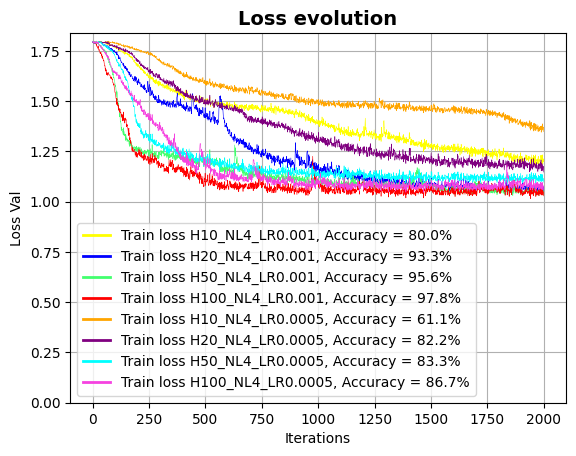

In [ ]:
custom_colors = ['yellow', 'blue', '#42ff6e', 'red', 'orange', 'purple', 'cyan', '#f542e0']

# Visualize loss function evolution
fig2 = plt.figure(2)
count = 0
for model, loss in losses_models.items():
    accuracy = np.round(test_accuracy_models[model] * 100, decimals=1)
    plt.plot(loss, label=f"Train loss {model}, Accuracy = {accuracy}%", linewidth=0.4, color=custom_colors[count])
    count += 1

plt.title(f'Loss evolution', fontsize=14, fontweight="bold")
plt.xlabel('Iterations')
plt.ylabel('Loss Val')
plt.ylim(0, None)
plt.grid()
legend = plt.legend()

# Legend line width (for visual purposes)
for line in legend.get_lines():
    line.set_linewidth(2)

if save_figure: plt.savefig(f"{output_path}fig2.png", dpi=300)

plt.show()

### Visualize the confusion matrix

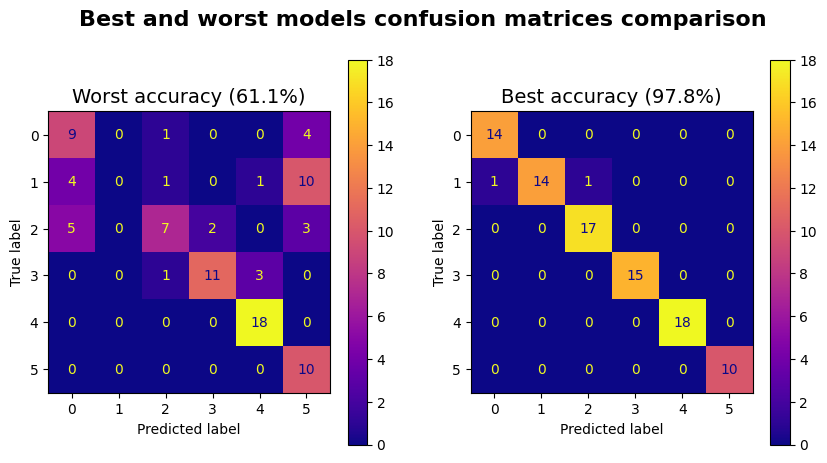

In [ ]:
# Visualize the best and worst confusion matrices
max_acc_model = max(test_accuracy_models, key=test_accuracy_models.get)
max_acc = np.round(test_accuracy_models[max_acc_model] * 100, decimals=1)
max_conf_matrix = confusion_matrix_models[max_acc_model]

less_acc_model = min(test_accuracy_models, key=test_accuracy_models.get)
less_acc = np.round(test_accuracy_models[less_acc_model] * 100, decimals=1)
less_conf_matrix = confusion_matrix_models[less_acc_model]

fig6, axs = plt.subplots(1, 2, figsize=(10, 5))
fig6.suptitle("Best and worst models confusion matrices comparison", fontsize=16, fontweight="bold")
axs[0].set_title(f"Worst accuracy ({less_acc}%)", fontsize=14)
axs[1].set_title(f"Best accuracy ({max_acc}%)", fontsize=14)
ConfusionMatrixDisplay(less_conf_matrix).plot(ax=axs[0], cmap="plasma")
ConfusionMatrixDisplay(max_conf_matrix).plot(ax=axs[1], cmap="plasma")


if save_figure: plt.savefig(f"{output_path}/fig6.png",dpi=300)
plt.show()


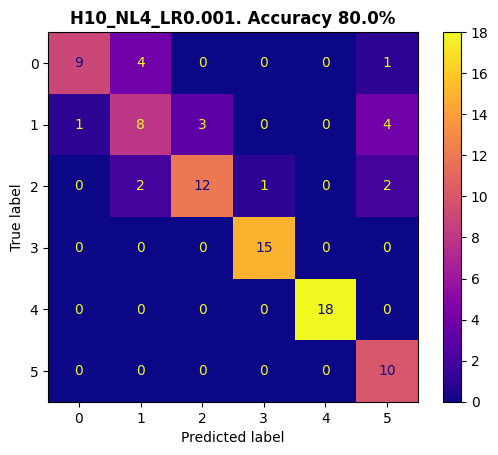

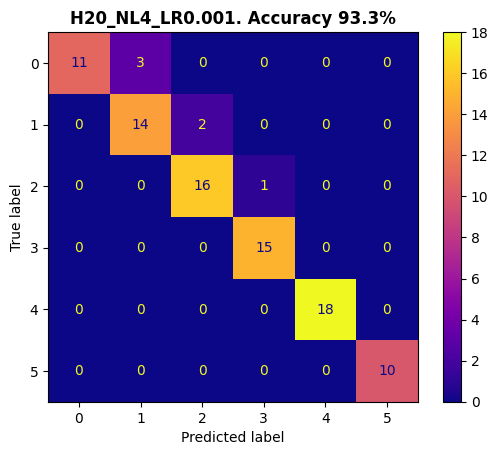

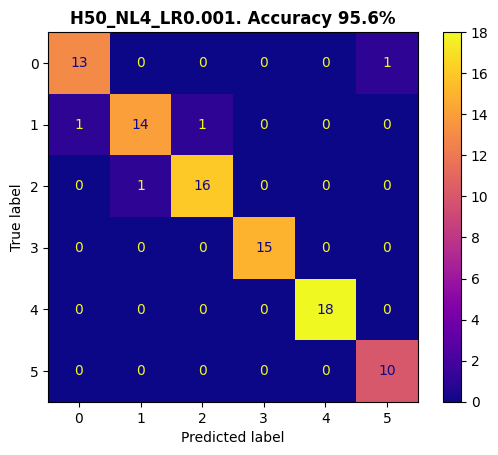

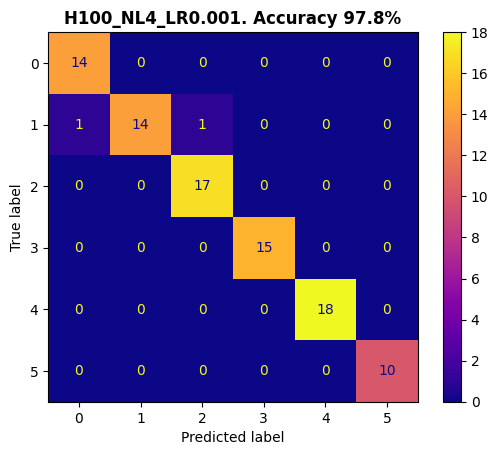

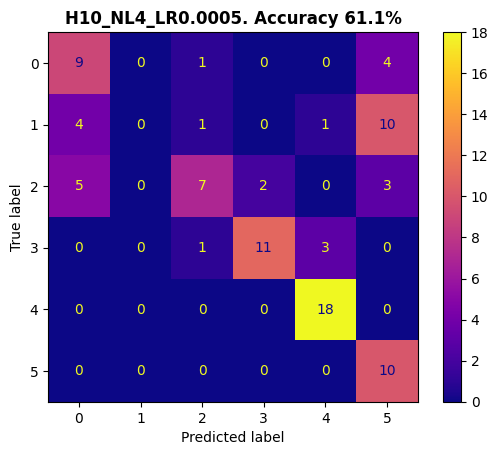

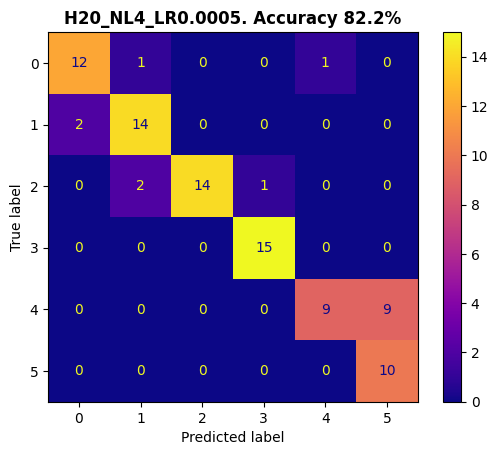

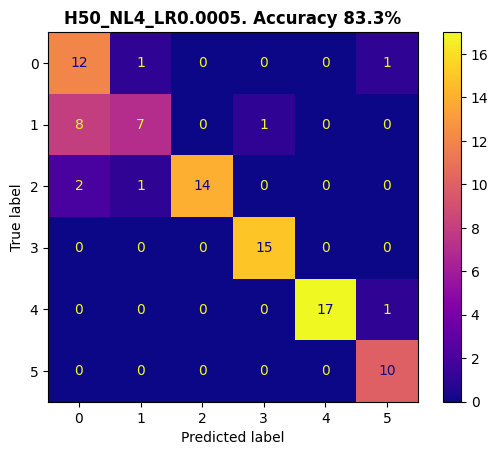

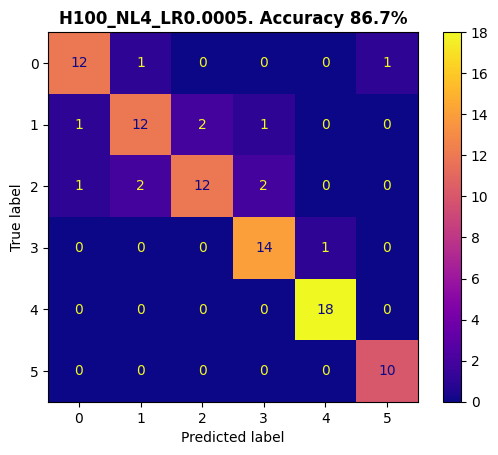

In [ ]:
# Visualize all the confusion matrices
for model, cm in confusion_matrix_models.items():
    accuracy = np.round(test_accuracy_models[model] * 100, decimals=1)
    fig = ConfusionMatrixDisplay(cm).plot(cmap="plasma")
    fig.ax_.set_title(f"{model}. Accuracy {accuracy}%", fontweight="bold")

plt.show()

# Ex 2. Cryptoanalysis with corrupted messages using RNNs/LSTMs

Similar to the exercise solved on P2-examples, you have to solve time-series modelling based on Cryptanalysis. 

For this exercise, you have `training.pkl` and `testing_corrupted.pkl` files. These files contain a new encrypted dataset of `10000` sentences, `8000` for training and `2000` for the test. Similar to the exercise solved in class, all the samples are encrypted using the *Vigenère cipher* with 7-length keyword. However, during the transmission of the test set, the encrypted data has been corrupted with a new char (`"-"`), while the training set has been transmitted correctly. 

Each 32-length sentence contains `4` corrupted chars randomly distributed on the test set, representing `12,5 %` of total data. Example:

```
Received Ciphertext:   'WCPS-VH-JHIKCUSETJV-AW-LPVUAHFHH'
Correct Ciphertext (Not provided):   'WCPSEVHAJHIKCUSETJVKAWGLPVUAHFHH'
Ground truth:   'HEWENTALLOUTANDGAVEITHISBESTSHOT'
```

**Steps**: 

1. **Discover the keyword** used to encrypt the plaintext data. (hint: use *Vigenère table* and some samples) manually?

2. Analyze the **data distribution** and define the new alphabet. Do plots (histogram)

3. Design/Implement an **strategy to train the model so that it can be robust** to missing characters in the testing samples ( to be discussed in class )

4. Train a **sequential model to decode the corrupted test** data. 

5. **Evaluate the decoding accuracy** for the test set in terms of characters that were not corrupted or corrupted independently.

6. Try to improve the performance by applying some improvements over the model: stacked LSTMs, hidden_sizes, embedding_size, optimizer, data augmentation during training, etc...

7. Visualize and discuss on the final results.

## Discover the keyword used to encrypt the plaintext data.
Hint: use Vigenère table and some samples

In [ ]:
# Default data provided for this exercise
with open(input_path + "training.pkl", "rb") as pkl_file:
    train = pickle.load(pkl_file)

with open(input_path + "testing_corrupted.pkl", "rb") as pkl_file:
    test = pickle.load(pkl_file)

# Additional data (attempt 1) found by us to improve the performance of the model
with open(input_path + "our_training.pkl", "rb") as pkl_file:
    our_train = pickle.load(pkl_file)
print(f'Our training dataset has {len(our_train)} sentences')

# Additional sentences (attempt 2, these ones are not cut at the end)
custom_data_path = 'CustomData/'
with open(custom_data_path + "sentences_32.pkl", "rb") as pkl_file:
    our_train2 = pickle.load(pkl_file)
print(f'Our training dataset (2) has {len(our_train2)} sentences')


# Vocabulary of the data including the `corrupted` symbol
vocabulary = [char for char in "ABCDEFGHIJKLMNOPQRSTUVWXYZ-"]


Our training dataset has 63516 sentences
Our training dataset (2) has 33851 sentences


In [ ]:
def decode_message(message, vocabulary):
    decoded = ""
    for letter_code in message:
        decoded += vocabulary[letter_code]
    return decoded


decoded_train_cypher = [decode_message(pair[0], vocabulary) for pair in train]
decoded_train_plaintext = [decode_message(pair[1], vocabulary) for pair in train]
decoded_test_cypher = [decode_message(pair[0], vocabulary) for pair in test]
decoded_test_plaintext = [decode_message(pair[1], vocabulary) for pair in test]

In [ ]:
# In the end we do not use the additional data (attempt 1), and we only use
# additional data (attempt 2). With more GPU memory, we would try to also use it.
our_train = decoded_train_plaintext
our_train += our_train2 # NOTE: Use slicing for just using a portion of the extra data

print(f'Training dataset has {len(our_train)} sentences')

Training dataset has 41851 sentences


### Discover the keyword

In [ ]:
def find_vigenere_keyword(plaintext, ciphertext, vocabulary):
    plaintext = plaintext.upper()
    ciphertext = ciphertext.upper()

    keyword = ""
    for i in range(len(plaintext)):
        p = uppercase_to_num(plaintext[i], vocabulary)  # Convert plaintext character to a numeric value (0-25)
        c = uppercase_to_num(ciphertext[i], vocabulary)  # Convert ciphertext character to a numeric value (0-25)
        k = (c - p) % 26  # Calculate the shift between the plaintext and ciphertext characters
        keyword += num_to_uppercase(k, vocabulary)  # Convert the shift value back to a character and append it to the keyword

    return keyword


encrypted1 = decode_message(train[0][0], vocabulary)
decrypted1 = decode_message(train[0][1], vocabulary)

keyword = find_vigenere_keyword(decrypted1, encrypted1, vocabulary)

print(f"The keyword used is: {keyword}\n")

The keyword used is: PYTORCHPYTORCHPYTORCHPYTORCHPYTO



### Verify that the found keyword is the one expected

In [ ]:
test_keyword = 3
for i in range(test_keyword):
    print("==================================================")
    print(f"Plaintext: {decode_message(train[i][1], vocabulary)}")
    our_encrypted = encrypt_message(decode_message(train[i][1], vocabulary), keyword, vocabulary)
    print(f"Encrypted plaintext: {our_encrypted}")
    print(f"Our encryption is equal to the encrypted message from dataset? {our_encrypted == decode_message(train[i][0], vocabulary)}")
    print("==================================================\n")


Plaintext: ILLCALLTHEMTOMORROWWHENICOMEBACK
Encrypted plaintext: XJEQRNSIFXAKQTDPKCNYOTLBQFOLQYVY
Our encryption is equal to the encrypted message from dataset? True

Plaintext: IDBEUNHAPPYBUTIWOULDNTKILLMYSELF
Encrypted plaintext: XBUSLPOPNIMSWAXUHICFUIIBZCOFHCET
Our encryption is equal to the encrypted message from dataset? True

Plaintext: ITHOUGHTYOULIKEDTOLEARNNEWTHINGS
Encrypted plaintext: XRACLIOIWHICKRTBMCCGHGLGSNVOXLZG
Our encryption is equal to the encrypted message from dataset? True



## Analyze the data distribution (of the original train and test datasets) and define the new alphabet

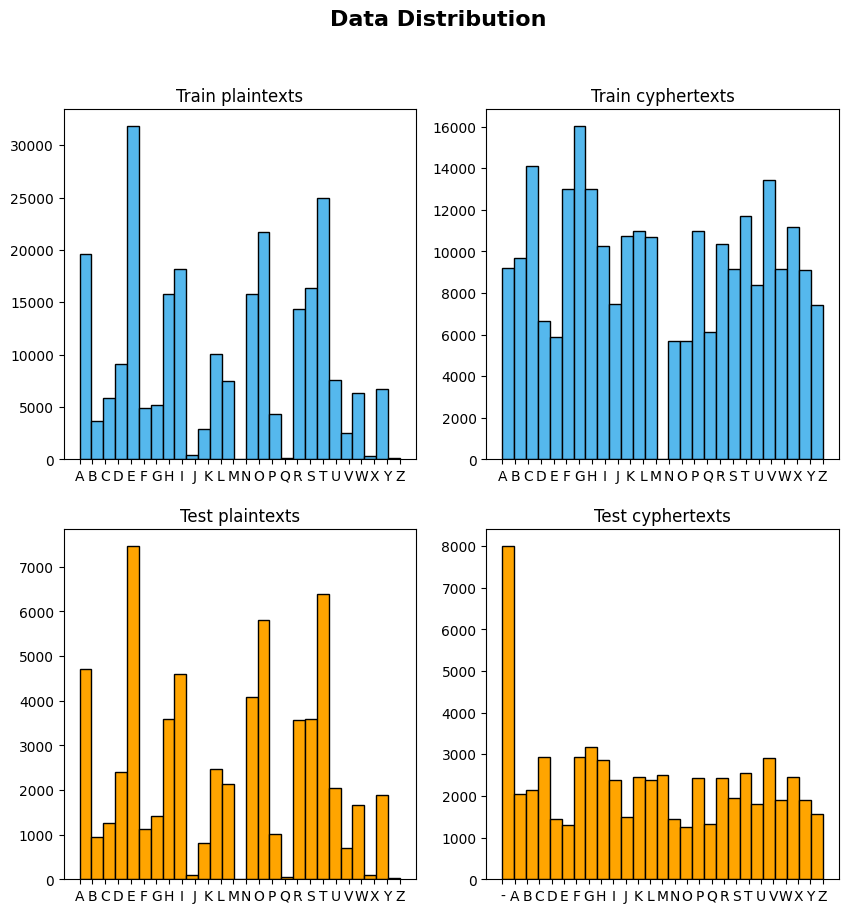

In [ ]:
train_cypher_chars = split_and_join(decoded_train_cypher)
train_cypher_chars = sorted(train_cypher_chars)

train_plaintext_chars = split_and_join(decoded_train_plaintext)
train_plaintext_chars = sorted(train_plaintext_chars)

test_cypher_chars = split_and_join(decoded_test_cypher)
test_cypher_chars = sorted(test_cypher_chars)

test_plaintext_chars = split_and_join(decoded_test_plaintext)
test_plaintext_chars = sorted(test_plaintext_chars)

bins = len(vocabulary)

fig3, axs = plt.subplots(2, 2, figsize=(10, 10))
fig3.suptitle("Data Distribution", fontsize="16", fontweight="bold")
axs[0, 0].hist(train_plaintext_chars, bins, color="#55b8ed", edgecolor="black")
axs[0, 0].set_title("Train plaintexts")
axs[0, 1].hist(train_cypher_chars, bins, color="#55b8ed", edgecolor="black")
axs[0, 1].set_title("Train cyphertexts")
axs[1, 0].hist(test_plaintext_chars, bins, color="orange", edgecolor="black")
axs[1, 0].set_title("Test plaintexts")
axs[1, 1].hist(test_cypher_chars, bins, color="orange", edgecolor="black")
axs[1, 1].set_title("Test cyphertexts")

if save_figure: plt.savefig(f"{output_path}/fig3.png", dpi=300)
plt.show()

## Design/Implement a strategy to train the model so that it can be robust to missing characters in the testing samples

In [ ]:
class DecrypterNetwork(nn.Module):
    def __init__( self, hidden_size: int = 8, num_layers=1, num_letters=26, letters_embedding_size: int = 8, use_lstm: bool = False, bidirectional_lstm=False, dropout: float = 0.01):
        # Define RNN or LSTM architecture
        super().__init__()
        self.hidden_size = hidden_size
        self.num_letters = num_letters
        self.letters_embedder = torch.nn.Embedding(num_letters, letters_embedding_size)
        self.use_lstm = use_lstm
        self.bidirectional = bidirectional_lstm
        self.softmax = nn.Softmax(dim=1)
        if use_lstm:
            self.rnn = nn.LSTM( input_size=letters_embedding_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, bidirectional=bidirectional_lstm, dropout=dropout)
        else:
            self.rnn = nn.RNN( input_size=letters_embedding_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)

        self.last_linear = nn.Linear(hidden_size * 2 if bidirectional_lstm else hidden_size, num_letters)

    def forward(self, X):
        N = X.shape[0]
        L = X.shape[1]

        embedded_letters = self.letters_embedder(X)
        
        # Get hidden states for all letters in the sequence
        hidden_states, _ = self.rnn(embedded_letters)
        
        # In case of multiple input sequneces flat (N,L,hidden_size) to (N*L,hidden_size) for linear layer
        hidden_states_concat = hidden_states.reshape(-1, self.hidden_size * 2 if self.bidirectional else self.hidden_size)
        
        # Get letters probability using the hidden states for each position in the sequence
        letters_loggits = self.last_linear(hidden_states_concat)
        
        # Use soft-max over logits and reshape to format (N,L,num_letteres)
        letters_probs = self.softmax(letters_loggits).reshape(N, L, self.num_letters)
        
        return letters_probs


### Functions to corrupt our dataset

In [ ]:
def corrupt_sentence(sentence: str, corruption_ratio: float = 0.125) -> str:
    """
    Given a sentece, it changes a certain amount of letters (depending on the
    corruption ratio) to hyphens.
    """
    num_hyphens = int(len(sentence) * corruption_ratio)
    numbers = random.sample(range(32), num_hyphens)

    sentence_as_list = list(sentence)
    for n in numbers:
        sentence_as_list[n] = "-"

    return "".join(sentence_as_list)


def corrupt_data(input_list: List[str], corruption_ratio: float = 0.125):
    """
    Corrupt all the sentences of a given input list.
    """
    output_list = []
    for sentence in input_list:
        output_list.append(corrupt_sentence(sentence, corruption_ratio))
    return output_list

### Corrupt our dataset

In [ ]:
corrupted_train_cypher = []
our_train_cypher = [encrypt_message(sentence, keyword, vocabulary) for sentence in our_train]
ratios = [0.3] # NOTE: 0.3 seems to be a good balance
splitted = np.array_split(our_train_cypher, len(ratios))
for idx, ratio in enumerate(ratios):
    corrupted_train_cypher += corrupt_data(splitted[idx], corruption_ratio=ratio)

corrupted_train = [[sentence_to_num(cypher, vocabulary), sentence_to_num(plaintext, vocabulary)] for cypher, plaintext in zip(corrupted_train_cypher, our_train)]

In [ ]:
"""
Given a model, train and test data and additional information to compute
multiple accuracies of the test dataset.

Sorry, we know this is not our cleanest code, but we did not have time to make
it more readable.
"""

def train_test( model, num_epochs, loss_fn, optimizer, seed_value, train_encrypted, train_decrypted, test_encrypted, test_decrypted, vocabulary, corrupted, non_corrupted, dropout=0.01):
    torch.manual_seed(seed_value)
    model = allocate(model, use_accel)
    train_encrypted = allocate(train_encrypted, use_accel)
    train_decrypted = allocate(train_decrypted, use_accel)
    test_encrypted = allocate(test_encrypted, use_accel)
    test_decrypted = allocate(test_decrypted, use_accel)
				
    accuracies, max_accuracy = [], 0
    loss_hist = []
    acc_hist = []
    corrupted_acc_hist = []
    non_corrupted_acc_hist = []
    epochs_hist = []
    test_loss_hist = []

    dropout = nn.Dropout(p=dropout)

    for epoch in range(num_epochs):
        # TRAINING AND BACK-PROPAGATION
        optimizer.zero_grad()
        letters_probs = model(train_encrypted)
        letters_probs = dropout(letters_probs.log().permute(0, 2, 1)) # rearrange as to (N_sequences, N_letters, N_lenght_sequences)
        loss = loss_fn(letters_probs, train_decrypted) # rearrange as to (N_sequences, N_letters, N_lenght_sequences)
        loss.backward()  # Backpropagate
        optimizer.step()  # Update weights
        loss_hist.append(loss.item())

        # EVALUATION
        letters_probs = model(test_encrypted)
        test_loss = loss_fn(letters_probs.log().permute(0, 2, 1), test_decrypted)  # rearrange as to (N_sequences, N_letters, N_lenght_sequences)
        _, maxprob_letters_idx = letters_probs.max(dim=2)  # get letter with maximum prob
        accuracy = ((maxprob_letters_idx == test_decrypted) * 1.0).mean()  # compute accuracy
        test_loss_hist.append(test_loss.item())
        acc_hist.append(accuracy.item())
        
        if epoch % 50 == 0:
            # Non-corrupted accuracy
            non_corrupted_positions, total_non_corrupted = non_corrupted
            correct_non_corrupted = 0
            for idx, sentence in enumerate(non_corrupted_positions):
                for letter_idx in sentence:
                    if maxprob_letters_idx[idx][letter_idx].item() == test_decrypted[idx][letter_idx]:
                        correct_non_corrupted += 1
            
            # Corrupted accuracy
            corrupted_positions, total_corrupted = corrupted
            correct_corrupted = 0
            for idx, sentence in enumerate(corrupted_positions):
                for letter_idx in sentence:
                    if maxprob_letters_idx[idx][letter_idx].item() == test_decrypted[idx][letter_idx]:
                        correct_corrupted += 1
            

            acc_non_corrupted = correct_non_corrupted / total_non_corrupted
            non_corrupted_acc_hist.append(acc_non_corrupted)
            acc_corrupted = correct_corrupted / total_corrupted
            corrupted_acc_hist.append(acc_corrupted)

            print(f"Epoch {epoch} \t Train Loss {round(loss.item(),3)} \t Test Loss {round(test_loss.item(),3)} \t Test Acc. (%)  {round(accuracy.item()*100,1)}")
            print(f"\tCorrect non corrupted: {correct_non_corrupted}\n\tAccuracy non_corrupted: {acc_non_corrupted * 100}%")
            print(f"\tCorrect corrupted: {correct_corrupted}\n\tAccuracy corrupted: {acc_corrupted * 100}%")
    
    print(f"Final Epoch \t Train Loss {round(loss.item(),3)} \t Test Loss {round(test_loss.item(),3)} \t Test Acc. (%)  {round(accuracy.item()*100,1)}")
    
    return model, loss_hist, test_loss_hist, acc_hist, corrupted_acc_hist, non_corrupted_acc_hist

### Compute data required for computing the corruption accuracy.

In [ ]:
# Converting training and testing datasets into PyTorch Tensor (N_seqs, lenght_seqs)
print('Type of corrupted_train:', type(corrupted_train), 'Length of corrupted train:', len(corrupted_train))

train_encrypted = torch.concat([train_sample[0].unsqueeze(0) for train_sample in corrupted_train], dim=0)
train_decrypted = torch.concat([train_sample[1].unsqueeze(0) for train_sample in corrupted_train], dim=0)
test_encrypted = torch.concat([test_sample[0].unsqueeze(0) for test_sample in test], dim=0)
test_decrypted = torch.concat([test_sample[1].unsqueeze(0) for test_sample in test], dim=0)

non_corrupted_positions = []
total_non_corrupted = 0
corrupted_positions = []
total_corrupted = 0

for idx, sentence in enumerate(test_encrypted):
    non_corrupted_positions.append([])
    corrupted_positions.append([])
    for i in range(len(sentence)):
        if decode_message([sentence[i].item()], vocabulary) != "-":
            non_corrupted_positions[idx].append(i)
            total_non_corrupted += 1
        else:
            corrupted_positions[idx].append(i)
            total_corrupted += 1

Type of corrupted_train: <class 'list'> Length of corrupted train: 41851


### Train the model

In [ ]:
# Initialize  Decrypter Network
letters_embedding_size = 20
hidden_size = 65
num_layers = 4
num_letters = len(vocabulary)
use_lstm = True
bidirectional = True
dropout = 0.1

torch.cuda.empty_cache()

decrypter_network = DecrypterNetwork(
    letters_embedding_size=letters_embedding_size,
    num_layers=num_layers,
    num_letters=num_letters,
    hidden_size=hidden_size,
    use_lstm=use_lstm,
    bidirectional_lstm=bidirectional,
    dropout=dropout
)

# Define loss, optimizer and run training/evaluation loop
num_epochs = 2000
CE_loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(decrypter_network.parameters(), lr=0.04)

decrypter_network, loss_hist, test_loss_hist, acc_hist, corrupted_acc_hist, non_corrupted_acc_hist = train_test(
    decrypter_network,
    num_epochs,
    CE_loss,
    optimizer,
    seed_value,
    train_encrypted,
    train_decrypted,
    test_encrypted,
    test_decrypted,
    vocabulary,
    [corrupted_positions, total_corrupted],
    [non_corrupted_positions, total_non_corrupted],
    dropout=dropout
)

Epoch 0 	 Train Loss 4.361 	 Test Loss 3.657 	 Test Acc. (%)  11.7
	Correct non corrupted: 6563
	Accuracy non_corrupted: 11.719642857142858%
	Correct corrupted: 905
	Accuracy corrupted: 11.3125%
Epoch 50 	 Train Loss 3.851 	 Test Loss 2.742 	 Test Acc. (%)  19.4
	Correct non corrupted: 11445
	Accuracy non_corrupted: 20.4375%
	Correct corrupted: 984
	Accuracy corrupted: 12.3%
Epoch 100 	 Train Loss 3.593 	 Test Loss 2.412 	 Test Acc. (%)  26.3
	Correct non corrupted: 15822
	Accuracy non_corrupted: 28.253571428571426%
	Correct corrupted: 1032
	Accuracy corrupted: 12.9%
Epoch 150 	 Train Loss 2.991 	 Test Loss 1.67 	 Test Acc. (%)  51.8
	Correct non corrupted: 31832
	Accuracy non_corrupted: 56.84285714285714%
	Correct corrupted: 1323
	Accuracy corrupted: 16.537499999999998%
Epoch 200 	 Train Loss 2.056 	 Test Loss 0.551 	 Test Acc. (%)  85.1
	Correct non corrupted: 52605
	Accuracy non_corrupted: 93.9375%
	Correct corrupted: 1868
	Accuracy corrupted: 23.35%
Epoch 250 	 Train Loss 1.883 	 T

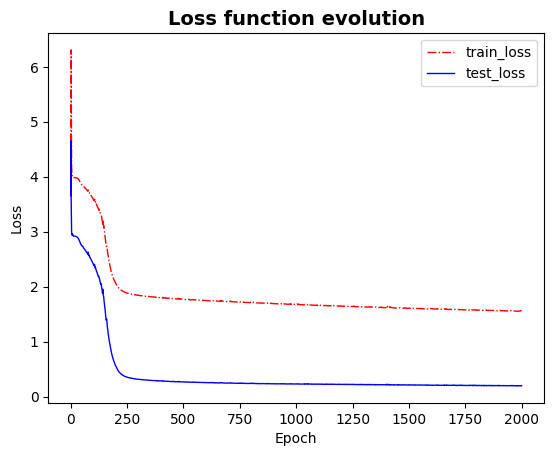

In [ ]:
fig4 = plt.figure(4)
plt.plot(loss_hist, "-.r", linewidth=1.0, label="train_loss")
plt.plot(test_loss_hist, "-b", linewidth=1.0, label="test_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss function evolution", fontsize=14, fontweight="bold")
plt.legend()

if save_figure: plt.savefig(f"{output_path}/fig4.png",dpi=300)
plt.show()

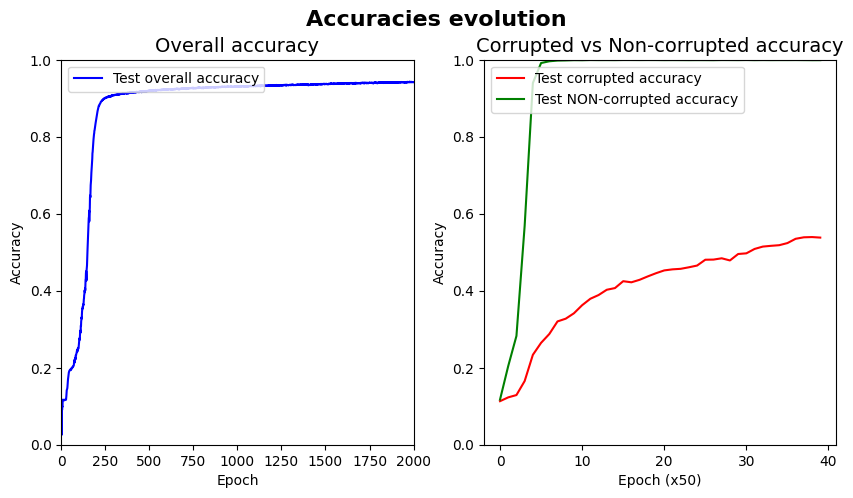

In [ ]:
fig5, axs = plt.subplots(1, 2, figsize=(10, 5))
fig5.suptitle("Accuracies evolution", fontsize=16, fontweight="bold")
axs[0].set_title("Overall accuracy", fontsize=14)
axs[1].set_title("Corrupted vs Non-corrupted accuracy", fontsize=14)
axs[0].plot(acc_hist, label="Test overall accuracy", color="blue")
for i in range(2):
    axs[i].set_ylabel("Accuracy")
    axs[i].set_ylim([0, 1])

axs[0].set_xlabel("Epoch")
axs[0].set_xlim([0, num_epochs])
axs[0].legend(loc="upper left")

axs[1].set_xlabel("Epoch (x50)")
axs[1].plot(corrupted_acc_hist, label="Test corrupted accuracy", color="red")
axs[1].plot(non_corrupted_acc_hist, label="Test NON-corrupted accuracy", color="green")
axs[1].legend(loc="upper left")

if save_figure: plt.savefig(f"{output_path}/fig5.png",dpi=300)
plt.show()

In [ ]:
decrypter_network = decrypter_network.cpu()
for idx_sample in range(0, 3):
    # Inference over single training sequence
    letters_probs = decrypter_network(test[idx_sample][0].unsqueeze(0))
    # get index of letter with max probability
    _, maxprob_letters_idx = letters_probs.max(dim=2)
    print("--------------------------------------")
    print(f"Original Message encrypted: {decode_message(test[idx_sample][0],vocabulary)}")
    print(f"Message decrypted: {decode_message(test[idx_sample][1],vocabulary)}")
    print(f"Prediction Message decrypted: {decode_message(maxprob_letters_idx[0],vocabulary)}")
    acc = (1.0 * (maxprob_letters_idx[0] == test[idx_sample][1])).mean().item()
    print(f"Prediction Message Accuracy : {round(acc,2)}")
